<a href="https://colab.research.google.com/github/bagusfadhlurrohman/Rangking/blob/main/Case_Study_IMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

IMDb Movie Award membuat segmen acara khusus untuk memberi penghargaan perfilman pada tahun 1990-1999. Tim produksi membutuhkan **daftar 5 nominasi dan 1 pemenang** pada penghargaan **Sutradara Film Horor Terbaik Tahun 90an**.

Gunakan data pada database yang tertera pada link di bawah ini.

https://relational.fit.cvut.cz/dataset/IMDb

# Install Dependencies

In [ ]:
!pip3 install mysql-connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp38-cp38-linux_x86_64.whl size=247965 sha256=df5ff92f82971a3e17e37f16c463c72e9ca1d5aab8802af6c55fe28bc963342a
  Stored in directory: /root/.cache/pip/wheels/57/e4/98/5feafb5c393dd2540e44b064a6f95832990d543e5b4f53ea8f
Successfully built mysql-connector


# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predefined Function

In [ ]:
def que(query, engine):
    df = pd.read_sql(query, engine)
    return df

# Data Collection

Dari problem statement di atas, saya menyimpulkan bahwa saya membutuhkan

*   Data sutradara
*   Data kualitas film sutradara
*   Data genre film sutradara
*   Metode untuk menghitung kualitas karya sutradara

In [ ]:
username = 'guest'
password = 'relational'
host = 'relational.fit.cvut.cz'
database = 'imdb_ijs'

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}")

In [ ]:
# check tables
query='''
    show tables
'''

que(query, engine)

,Tables_in_imdb_ijs
0,actors
1,directors
2,directors_genres
3,movies
4,movies_directors
5,movies_genres
6,roles


In [ ]:
# print first 5 rows of each tables
query='''
    show tables
'''

tables = que(query, engine)

for i in tables.Tables_in_imdb_ijs:
  query='''
      select * from ''' + i + '''
      limit 5
      
  '''

  print('TABLE:', i)
  print(que(query, engine))
  print()

TABLE: actors
   id first_name           last_name gender
0   2    Michael  'babeepower' Viera      M
1   3       Eloy         'Chincheta'      M
2   4   Dieguito         'El Cigala'      M
3   5    Antonio    'El de Chipiona'      M
4   6       José        'El Francés'      M

TABLE: directors
   id first_name    last_name
0   1       Todd            1
1   2        Les  12 Poissons
2   3    Lejaren     a'Hiller
3   4       Nian            A
4   5   Khairiya    A-Mansour

TABLE: directors_genres
   director_id        genre  prob
0            2        Short   1.0
1            3        Drama   1.0
2            5  Documentary   1.0
3            6        Drama   1.0
4            6        Short   1.0

TABLE: movies
   id                                 name  year  rank
0   0                                  #28  2002   NaN
1   1  #7 Train: An Immigrant Journey, The  2000   NaN
2   2                                    $  1971   6.4
3   3                        $1,000 Reward  1913   NaN
4   4

Dari output di atas, kemungkinan tabel yang digunakan adalah


*   directors
*   directors_genres
*   movies_directors
*   movies_genres
*   movies

Dari keseluruhan data tersebut, kolom `prob` pada tabel `directors_genres` sedikit ambigu untuk nilai dan konteksnya. Maka dari itu perlu explorasi lebih lanjut.





In [ ]:
query='''
    select gender, count(*)
    from actors
    group by gender
'''

que(query, engine)

,gender,count(*)
0,F,304412
1,M,513306


In [ ]:
query='''
    select min(prob), avg(prob), max(prob)
    from directors_genres
'''

que(query, engine)

,min(prob),avg(prob),max(prob)
0,0.001621,0.634452,1.0


Asumsi sementara, `prob` merupakan kolom berisi persentase genre seorang sutradara terhadap semua karyanya. Disimpulkan dari range nilainya dari 0 - 1.

In [ ]:
query='''
    with director_id_min as (
      select director_id from directors_genres
      where prob = (select min(prob) from directors_genres)
    )

    select dim.director_id, dg.genre, dg.prob
    from directors_genres dg join director_id_min dim
    on dg.director_id = dim.director_id
'''

que(query, engine)

,director_id,genre,prob
0,25116,Action,0.001621
1,25116,Action,0.001621
2,25116,Adventure,0.003241
3,25116,Adventure,0.003241
4,25116,Animation,0.995138
5,25116,Animation,0.995138
6,25116,Comedy,0.410049
7,25116,Comedy,0.410049
8,25116,Documentary,0.003241
9,25116,Documentary,0.003241


Dari output query di atas, ditemukan bahwa seorang sutradara dapat memiliki berbagai genre dengan nilai `prob` yang berbeda-beda. Namun, data masih dirasa ambigu karena ketika semua nilai dijumlah totalnya melebihi 1. Dengan begitu saya memutuskan untuk tidak menggunakan tabel `directors_genres` pada analisis kali ini.

In [ ]:
# cek penulisan genre 'Horror' pada data
query='''
    select distinct genre
    from movies_genres
'''

que(query, engine)

,genre
0,Documentary
1,Short
2,Comedy
3,Crime
4,Western
5,Family
6,Animation
7,Drama
8,Romance
9,Mystery


In [ ]:
# query untuk mengambil data yang akan dianalisis
query='''
    select m.id as movie_id, m.name as movie_name, m.year as movie_year, m.rank as movie_rating, mg.genre as movie_genre, md.director_id, concat(d.first_name, " ", d.last_name) as director_name
    from movies m
      left join movies_genres mg on m.id = mg.movie_id
      left join movies_directors md on m.id = md.movie_id
      left join directors d on md.director_id = d.id
    where m.year between 1990 and 1999
    and mg.genre = 'Horror'
'''

df = que(query, engine)
df

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name
0,118,'Halloween' Unmasked 2000,1999,NaN,Horror,13171.0,Mark Cerulli
1,302,'Zmeiny istochnik,1997,NaN,Horror,45259.0,Nikolai (IV) Lebedev
2,675,100 Days,1991,5.9,Horror,28286.0,Partho Ghosh
3,724,100 Years of Horror,1996,NaN,Horror,57638.0,Ted Newsom
4,725,100 Years of Horror: Freaks,1996,NaN,Horror,NaN,None
...,...,...,...,...,...,...,...
1890,375716,Zombies Ate My Neighbors,1993,NaN,Horror,NaN,None
1891,375733,"Zona del silencio, La",1990,NaN,Horror,18329.0,Rodolfo de Anda
1892,376640,Aqu espaantan!,1993,4.5,Horror,7485.0,Joaquín Bissner
1893,376692,Mtenme porque me muero!,1991,NaN,Horror,13917.0,Abraham Cherem


Dengan mempertimbangkan ketersediaan data, asumsi sementara akan dilakukan metode scoring pada tiap sutradara berdasarkan rating film dan jumlah film yang dirilis. Maka dari itu, data diambil dari tabel-tabel berikut:
*   directors
*   movies_directors
*   movies_genres
*   movies

# Data Cleaning

## Check Null Values

In [ ]:
df.isna().sum()

movie_id           0
movie_name         0
movie_year         0
movie_rating     915
movie_genre        0
director_id      140
director_name    140
dtype: int64

Terdapat null values pada 3 kolom dengan jumlah yang cukup tinggi. `movie_rating` merupakan variabel utama dalam menentukan kualitas seorang sutradara. Maka dari itu baris data dengan nulls pada kolom `movie_rating` akan dihapus. Begitu juga dengan `director_id` dan `director_name` akan dihapus baris datanya jika memiliki nulls pada kolom-kolom tersebut karena tidak dapat diidentifikasi sutradaranya.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name
2,675,100 Days,1991,5.9,Horror,28286.0,Partho Ghosh
19,1710,2001 Yonggary,1999,3.0,Horror,73101.0,Hyung-rae Shim
20,2253,"301, 302",1995,6.8,Horror,60716.0,Cheol-su Park
21,2254,303 Fear Faith Revenge,1998,6.1,Horror,75566.0,Somching Srisupap
22,2349,3615 code Pre Nol,1990,5.3,Horror,50082.0,René Manzor
...,...,...,...,...,...,...,...
1875,375682,Zombi 1,1995,3.9,Horror,64628.0,Richard Raaphorst
1876,375685,"Zombi de Cap-Rouge, Le",1997,2.7,Horror,67132.0,Simon Robideaux
1877,375685,"Zombi de Cap-Rouge, Le",1997,2.7,Horror,74635.0,Alan Smithee
1882,375696,Zombie Cop,1991,1.5,Horror,8481.0,J.R. Bookwalter


## Check Irregular Values

In [ ]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 2 to 1892
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       976 non-null    int64  
 1   movie_name     976 non-null    object 
 2   movie_year     976 non-null    int64  
 3   movie_rating   976 non-null    float64
 4   movie_genre    976 non-null    object 
 5   director_id    976 non-null    float64
 6   director_name  976 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 61.0+ KB


Ditemukan dua ketidak sesuaian tipe data yaitu pada `movie_id` dan `director_id`. Kolom keterangan id sebaiknya disimpan dalam tipe data string karena tidak ditujukan untuk proses kalkulasi apapun.

In [ ]:
# data type adjustment
df['movie_id'] = df['movie_id'].astype(str)
df['director_id'] = df['director_id'].astype(int).astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 2 to 1892
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       976 non-null    object 
 1   movie_name     976 non-null    object 
 2   movie_year     976 non-null    int64  
 3   movie_rating   976 non-null    float64
 4   movie_genre    976 non-null    object 
 5   director_id    976 non-null    object 
 6   director_name  976 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 61.0+ KB


In [ ]:
df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name
2,675,100 Days,1991,5.9,Horror,28286,Partho Ghosh
19,1710,2001 Yonggary,1999,3.0,Horror,73101,Hyung-rae Shim
20,2253,"301, 302",1995,6.8,Horror,60716,Cheol-su Park
21,2254,303 Fear Faith Revenge,1998,6.1,Horror,75566,Somching Srisupap
22,2349,3615 code Pre Nol,1990,5.3,Horror,50082,René Manzor


In [ ]:
# check movie_year values, the values supposed to be >= 1990 and <= 1999 only
sorted(df['movie_year'].unique())

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]

In [ ]:
# check movie_genre values, the values supposed to be 'Horror' only
df['movie_genre'].unique()

array(['Horror'], dtype=object)

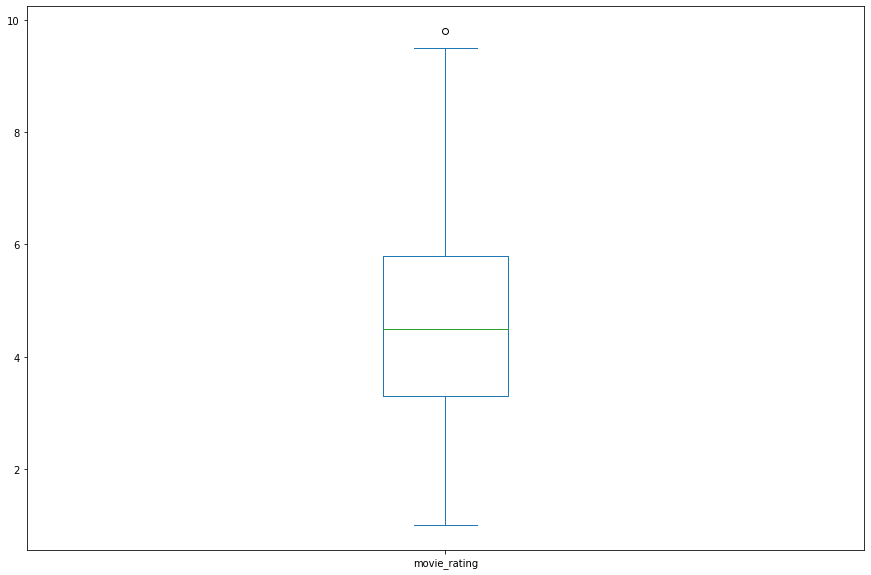

In [ ]:
# check outlier in movie_rating
df['movie_rating'].plot.box(figsize=(15,10))

Ditemukan 1 outlier pada `movie_rating`. Namun tidak perlu dilakukan outlier handling karena nilai outlier masih dalam range yang wajar pada konteks rating film yang pada umumnya adalah 0-10.

In [ ]:
df['movie_rating'].describe()

count    976.000000
mean       4.549590
std        1.676902
min        1.000000
25%        3.300000
50%        4.500000
75%        5.800000
max        9.800000
Name: movie_rating, dtype: float64

## Check Duplicate Values

In [ ]:
df[df.duplicated(keep=False)]

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name


Tidak ditemukan duplicate yang melibatkan seluruh kolom.

In [ ]:
df[df.duplicated(subset=['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_genre'], keep=False)]

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name
42,6697,Adrnaline,1990,5.5,Horror,3201,Anita Assal
43,6697,Adrnaline,1990,5.5,Horror,8325,Barthélémy Bompard
44,6697,Adrnaline,1990,5.5,Horror,20845,Philippe Dorison
45,6697,Adrnaline,1990,5.5,Horror,35778,John (V) Hudson
46,6697,Adrnaline,1990,5.5,Horror,49063,Jean-Marie Maddeddu
...,...,...,...,...,...,...,...
1853,371583,Yin yang lu,1997,6.8,Horror,13903,Wai-Man Cheng
1854,371583,Yin yang lu,1997,6.8,Horror,78067,Long-Cheung Tam
1855,371583,Yin yang lu,1997,6.8,Horror,87201,Herman Yau
1876,375685,"Zombi de Cap-Rouge, Le",1997,2.7,Horror,67132,Simon Robideaux


Ketika dilakukan checking duplicates dengan subset kolom khusus movie, ditemukan bahwa dalam 1 film terdapat kemungkinan ada lebih dari 1 sutradara yang mengerjakan.

In [ ]:
print('unique director_id:', len(df['director_id'].unique()))
print('unique director_name:', len(df['director_name'].unique()))

unique director_id: 777
unique director_name: 777


Jumlah unique values kolom `director_id` dan `director_name` seharusnya sama karena 1 id sutradara tidak boleh merepresentasikan lebih dari 1 sutradara. Setelah dilakukan checking unique values dapat dipastikan data sutradara telah valid.

In [ ]:
print('unique movie_id:', len(df['movie_id'].unique()))
print('unique movie_name:', len(df['movie_name'].unique()))

unique movie_id: 881
unique movie_name: 877


Jumlah unique values kolom `movie_id` dan `movie_name` seharusnya sama karena 1 id film tidak boleh merepresentasikan lebih dari 1 film. Namun ketika dilakukan checking unique values pada kolom `movie_id` dan `movie_name`, ditemukan bahwa jumlah `movie_id` lebih banyak daripada `movie_name`.

In [ ]:
tmp = df[['movie_id', 'movie_name']].drop_duplicates()
tmp = tmp[tmp.duplicated(subset=['movie_name'], keep=False)]
tmp

,movie_id,movie_name
263,53132,Campfire Tales
265,53133,Campfire Tales
750,140076,Haunted
751,140077,Haunted
787,145101,Highway to Hell
788,145102,Highway to Hell
934,176899,Killers
935,176900,Killers


Setelah ditinjau lebih dalam, terdapat beberapa `movie_id` yang memiliki `movie_name` identik. 

In [ ]:
df[df['movie_name'].isin(tmp['movie_name'])]

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_id,director_name
263,53132,Campfire Tales,1991,4.3,Horror,15804,William Cooke
264,53132,Campfire Tales,1991,4.3,Horror,78030,Paul (I) Talbot
265,53133,Campfire Tales,1997,5.5,Horror,15852,Matt (I) Cooper
266,53133,Campfire Tales,1997,5.5,Horror,43325,Martin Kunert
267,53133,Campfire Tales,1997,5.5,Horror,72107,David Semel
750,140076,Haunted,1995,6.2,Horror,28507,Lewis (II) Gilbert
751,140077,Haunted,1998,5.1,Horror,19845,Dennis Devine
787,145101,Highway to Hell,1990,5.6,Horror,52000,Bret McCormick
788,145102,Highway to Hell,1992,5.1,Horror,38522,Ate de Jong
934,176899,Killers,1996,6.3,Horror,52960,Mike (I) Mendez


Hasil penelusuran lebih lanjut menunjukkan bahwa terdapat beberapa film berbeda dengan nama yang identik. Hal ini dapat dibuktikan dengan perbedaan rating film, tahun produksi, dan nama sutradara. Karena penyebabnya adalah nama film yang identik, maka dapat dipastikan setiap `movie_id` merepresentasikan film yang berbeda.

# Data Analysis

Dalam analisis ini, kolom id dan genre film sudah tidak diperlukan lagi sehingga dilakukan drop pada kolom-kolom tersebut.

In [ ]:
analyze = df.drop(columns=['movie_id', 'movie_genre', 'director_id'])
analyze

,movie_name,movie_year,movie_rating,director_name
2,100 Days,1991,5.9,Partho Ghosh
19,2001 Yonggary,1999,3.0,Hyung-rae Shim
20,"301, 302",1995,6.8,Cheol-su Park
21,303 Fear Faith Revenge,1998,6.1,Somching Srisupap
22,3615 code Pre Nol,1990,5.3,René Manzor
...,...,...,...,...
1875,Zombi 1,1995,3.9,Richard Raaphorst
1876,"Zombi de Cap-Rouge, Le",1997,2.7,Simon Robideaux
1877,"Zombi de Cap-Rouge, Le",1997,2.7,Alan Smithee
1882,Zombie Cop,1991,1.5,J.R. Bookwalter


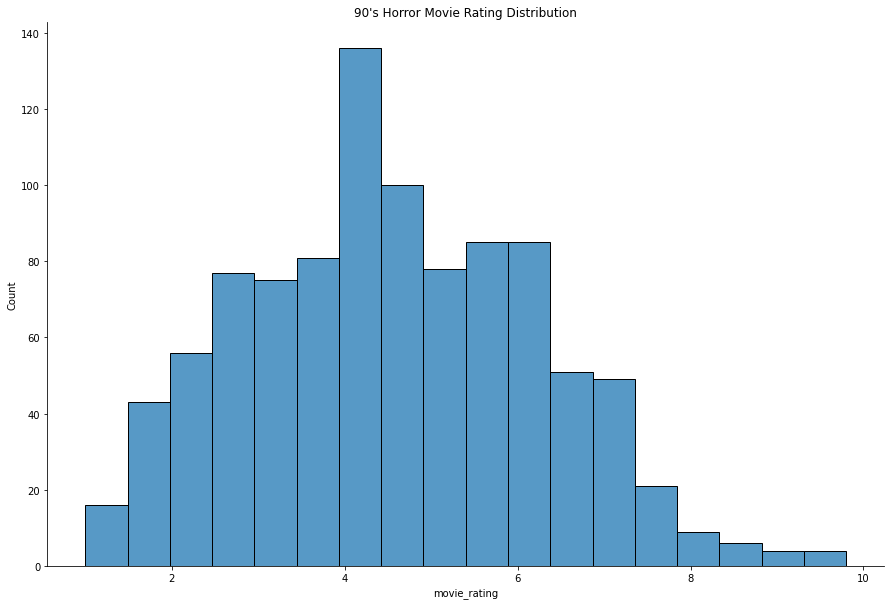

In [ ]:
plt.figure(figsize=(15,10))
plt.title('90\'s Horror Movie Rating Distribution')
sns.histplot(analyze['movie_rating'])
sns.despine()
plt.show()

Distribusi rating film banyak terpusat pada rating 4-5 dan sangat sedikit pada nilai rating 8 ke atas. Hal ini dapat menunjang asumsi analisis dalam menggunakan rating film sebagai variabel penilaian karena jumlah film dengan nilai rating tinggi sedikit jumlahnya. Dengan begitu, akan mudah dibedakan sutradara dengan rating film tinggi dengan yang rata-rata.

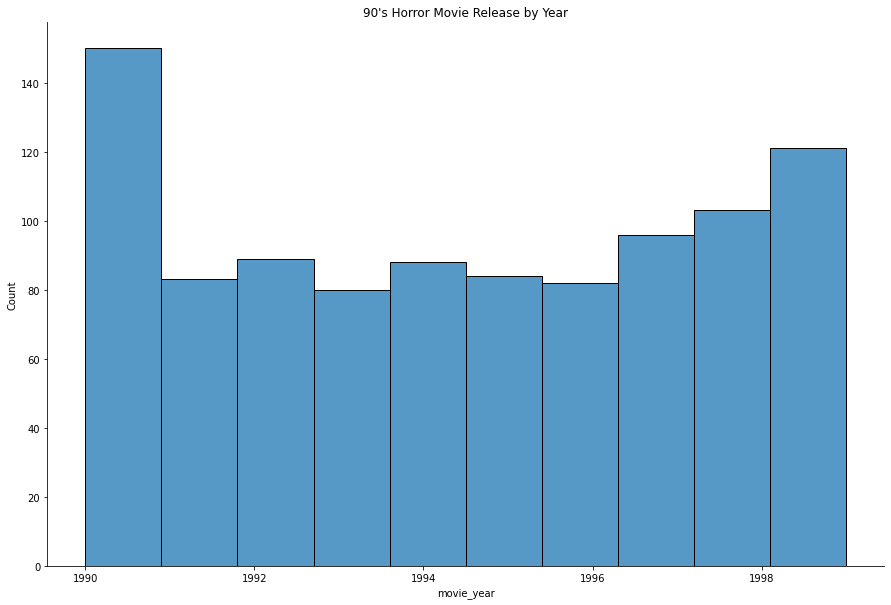

In [ ]:
plt.figure(figsize=(15,10))
plt.title('90\'s Horror Movie Release by Year')
sns.histplot(analyze['movie_year'], bins=10)
sns.despine()
plt.show()

Film horor paling banyak diproduksi pada tahun 1990-1991. Setelah itu cukup stagnan hingga mengalami peningkatan kembali mendekati tahun 2000.

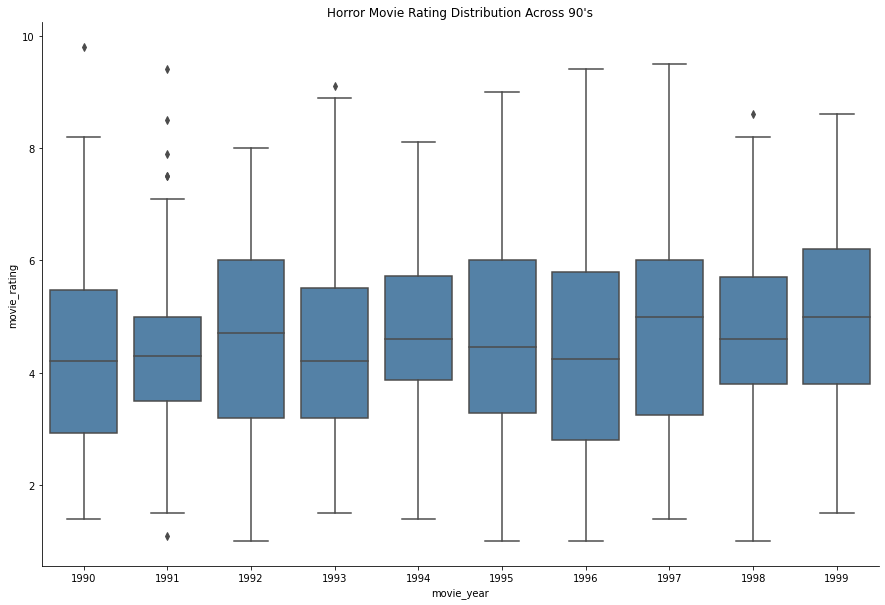

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Horror Movie Rating Distribution Across 90\'s')
sns.boxplot(data=analyze, x='movie_year', y='movie_rating',
            color='steelblue')
sns.despine()
plt.show()

Berdasarkan boxplot di atas, tidak ditemukan satu periode waktu dengan kualitas film yang tinggi secara mayoritas. Namun dapat dilihat bahwa film dengan rating tertinggi selama 1 dekade diproduksi pada tahun 1990.

Dalam melakukan pembobotan / penilaian sutradara, perlu dilakukan penyesuaian data yang awalnya grouped by film menjadi grouped by sutradara. Grouping per sutradara dilakukan agar mendapatkan nilai `movie_count` dan `movie_rating_mean` per sutradara.

In [ ]:
# group by director and generate scoring features
analyze = analyze.groupby('director_name').agg(movie_count=('movie_name', 'size'),
                                                movie_rating_mean=('movie_rating', 'mean'))\
                                                .reset_index()

In [ ]:
analyze

,director_name,movie_count,movie_rating_mean
0,Adam (I) Grossman,2,2.8
1,Adam (I) Simon,2,4.5
2,Adam Marcus,1,3.8
3,Adam Rifkin,2,3.0
4,Adrian Lyne,1,7.2
...,...,...,...
772,Yoshimitsu Morita,1,7.4
773,Yuet Sang Chin,1,8.2
774,Yukihiko Tsutsumi,1,6.8
775,Yuzo Sato,1,4.3


Rating film diproses dengan agregasi mean karena terdapat kemungkinan bahwa satu sutradara memiliki beberapa rating film.

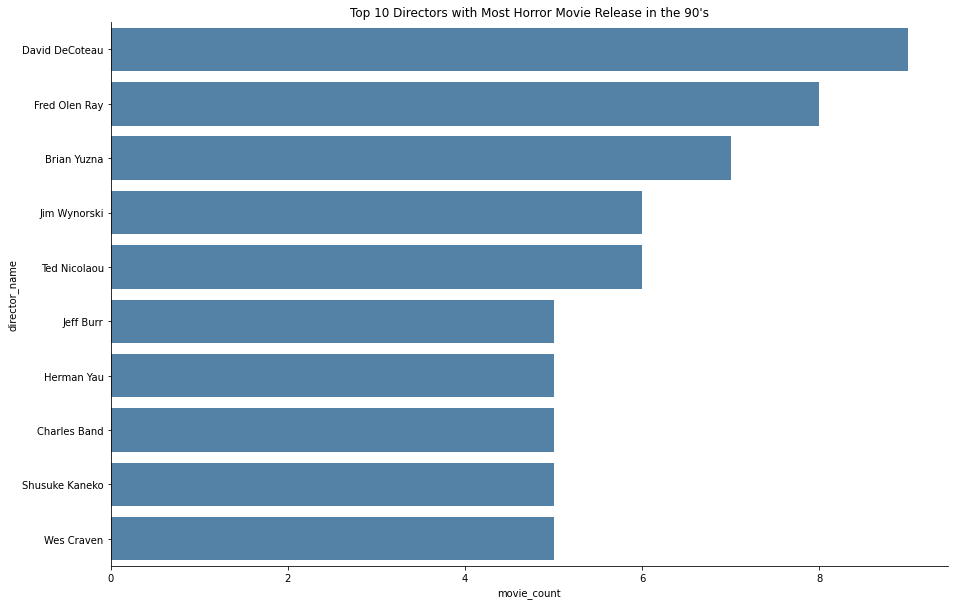

In [ ]:
high_movie_count = analyze.sort_values(by='movie_count', ascending=False).head(10)

plt.figure(figsize=(15,10))
plt.title('Top 10 Directors with Most Horror Movie Release in the 90\'s')
sns.barplot(data=high_movie_count, x='movie_count', y='director_name',
            color='steelblue', )
sns.despine()
plt.show()

Dengan data hasil agregasi, sutradara dapat diurutkan berdasarkan berbagai cara. Salah satunya adalah berdasarkan jumlah film yang telah dirilis. Dapat dilihat di atas bahwa sutradara yang paling banyak merilis film dalam satu dekade 90-99 adalah David DeCoteau dengan jumlah film sebanyak 9.

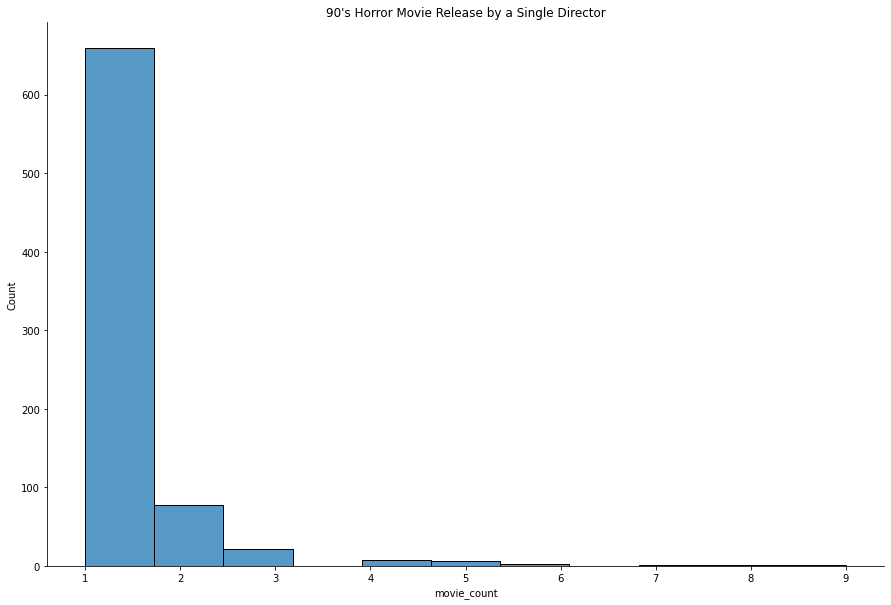

In [ ]:
plt.figure(figsize=(15,10))
plt.title('90\'s Horror Movie Release by a Single Director')
sns.histplot(analyze['movie_count'])
sns.despine()
plt.show()

Namun jika dilihat dari distribusi jumlah rilis film per sutradara, data terpusat pada angka 1. Dapat disimpulkan bahwa dalam satu dekade, kebanyakan sutradara hanya merilis 1 film saja. Sangat jarang sutradara yang merilis lebih dari 3 film.

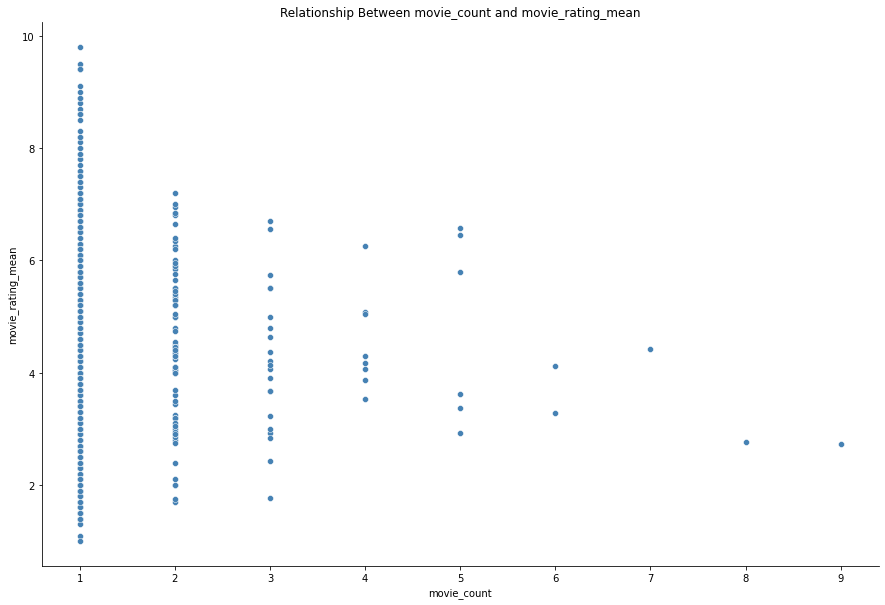

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Relationship Between movie_count and movie_rating_mean')
sns.scatterplot(data=analyze, x='movie_count', y='movie_rating_mean',
            color='steelblue')
sns.despine()
plt.show()

Jika dilihat hubungan antara jumlah rilis film dengan rata-rata rating film, tidak ditemukan korelasi diantara keduanya. Hal ini menggambarkan bahwa sutradara yang merilis banyak film menghasilkan film dengan rating yang baik. Bahkan rating film di atas 8 semuanya diproduksi oleh sutradara yang fokus satu film saja. Dengan begitu saya putuskan untuk tidak menggunakan variabel `movie_count` dalam penilaian sutradara.

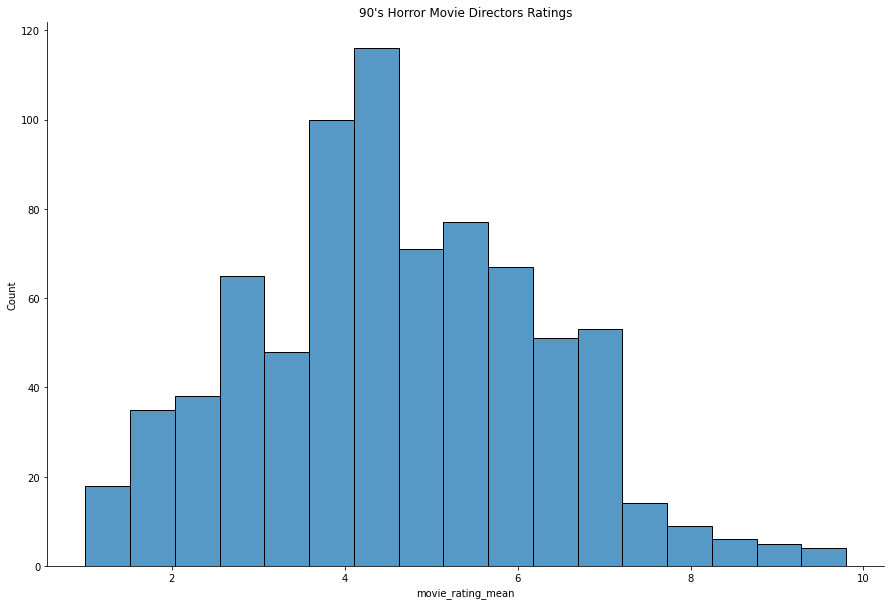

In [ ]:
plt.figure(figsize=(15,10))
plt.title('90\'s Horror Movie Directors Ratings')
sns.histplot(analyze['movie_rating_mean'])
sns.despine()
plt.show()

Sebagai keputusan akhir dalam metode penilaian sutradara, hanya `movie_rating_mean` yang digunakan karena variabel ini secara eksplisit merepresentasikan kualitas karya para sutradara dan datanya didapatkan langsung dari para penonton atau kritikus filmnya.

# Conclusions

Daftar nominasi didapatkan dengan mengurutkan data sutradara berdasarkan `movie_rating_mean` dari yang paling tinggi hingga yang paling rendah.

In [ ]:
analyze.sort_values(by='movie_rating_mean', ascending=False)

,director_name,movie_count,movie_rating_mean
186,Djordje Kadijevic,1,9.8
530,Mix Ryan,1,9.5
411,Ken Lidster,1,9.4
645,Scott Mabbutt,1,9.4
589,Ricardo Islas,1,9.1
...,...,...,...
611,Rocco Karega,1,1.4
276,Hal Miles,1,1.4
635,S. Torriano Berry,1,1.3
228,Francis Patrick Creighton,1,1.1


Maka berdasarkan rata-rata rating film. Didapatkan daftar nominasi dan pemenang sebagai berikut.

In [ ]:
nominee = analyze.sort_values(by='movie_rating_mean', ascending=False).iloc[:5,0]
winner = nominee.iloc[0]

print('Nominasi Sutradara Film Horor Terbaik Tahun 90an:')
for i in nominee:
  print('-',i)

print()
print('Sutradara Film Horor Terbaik Tahun 90an:\n-',winner)

Nominasi Sutradara Film Horor Terbaik Tahun 90an:
- Djordje Kadijevic
- Mix Ryan
- Ken Lidster
- Scott Mabbutt
- Ricardo Islas

Sutradara Film Horor Terbaik Tahun 90an:
- Djordje Kadijevic
